### Necessary imports
Imports all necessary packages for this project

In [140]:
# import libraries
import pandas as pd
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from langdetect import detect, DetectorFactory
from deep_translator import GoogleTranslator

### Dataset
The cybersecurity job market is constantly evolving, and LinkedIn hosts numerous job advertisements related to the field. To ensure the dataset reflects current real-world demands, updated job postings were collected.

After some research, a useful Chrome extension was identified:

**ScrapeJob – LinkedIn Jobs Scraper:**

With proper configuration, this tool extracts job listings, company details, and job poster information from LinkedIn postings.

For more details, visit:
https://linkedin.scrapejob.net/

In [116]:
# load the data
data = pd.read_json('data/li_jobs.json')

### Data exploration

In [117]:
# number of rows / samples
row_count = data.shape[0]
row_count

604

In [118]:
# print the first few rows of the data
data.head()

,Title,Description,Primary Description,Detail URL,Location,Skill,Insight,Job State,Poster Id,Company Name,...,Headquarters,Company Founded,Specialties,Hiring Manager Title,Hiring Manager Subtitle,Hiring Manager Title Insight,Hiring Manager Profile,Hiring Manager Image,Created At,Scraped At
0,Mitarbeiter Organisationsmanagement & Prozesso...,Standort: Lohr a.MainBeschäftigungsverhältnis:...,Raiffeisen Immobilien-Dienstleistungs GmbH · L...,https://www.linkedin.com/jobs/view/4169550707,"Lohr, Bavaria, Germany","Skills: Spanish, Artificial Intelligence (AI),...",,LISTED,1479512611,,...,,,,,,,,,2025-02-28T14:24:34.000Z,2025-03-04T20:51:54.642Z
1,Senior Operations & Automation Manager – Label...,\n\nYour mission\n\n\n\nAbout Label OS\n\nLabe...,"iGroove · Berlin, Berlin, Germany (On-site)",https://www.linkedin.com/jobs/view/4144186025,"Berlin, Berlin, Germany","Skills: Soft Skills, Data Analytics, +8 more",,LISTED,222132374,iGroove,...,Pfäffikon,2013,"Digital Music Distribution,Label Services,Arti...",Patrick Lawritsch,COO iGroove // Entrepreneur | Trusted Expert \...,3rd,https://www.linkedin.com/in/plawritsch,https://media.licdn.com/dms/image/v2/C4D03AQGV...,2025-02-07T18:59:15.000Z,2025-03-04T20:52:05.978Z
2,Middelbaar Veiligheidskundige,Ben jij dé specialist in arbeidsveiligheid en ...,"Groothuis Bouw Emmeloord · Emmeloord, Flevolan...",https://www.linkedin.com/jobs/view/4118527660,"Emmeloord, Flevoland, Netherlands",,,LISTED,653913933,Groothuis Bouw Emmeloord,...,Emmeloord,,"Het bouwen van vrijstaande woningen,Traditione...",,,,,,2025-01-07T12:08:16.000Z,2025-03-04T20:52:16.825Z
3,Security consultant - SIEM,Hľadáme odborníka na technológiu SIEM a oblasť...,"exe, a.s. · Bratislava Metropolitan Area (Hybrid)",https://www.linkedin.com/jobs/view/4153637949,Bratislava Metropolitan Area,"Skills: Information Security, Cybersecurity, +...",,LISTED,449502629,"exe, a.s.",...,Bratislava,1990,"Projecting Enterprise Information Systems,Soft...",,,,,,2025-02-18T06:43:37.000Z,2025-03-04T20:52:28.790Z
4,Information Technology Graduate,"CityLearning, a leading provider of compliance...","CityLearning · Dublin, County Dublin, Ireland ...",https://www.linkedin.com/jobs/view/4170246916,"Dublin, County Dublin, Ireland",8 of 10 skills match your profile - you may be...,,LISTED,72468613,CityLearning,...,Dublin 2,1998,"GDPR,Data Protection,Combat Money Laundering,I...",,,,,,2025-03-01T12:42:16.000Z,2025-03-04T20:52:39.856Z


In [119]:
data.columns

Index(['Title', 'Description', 'Primary Description', 'Detail URL', 'Location',
       'Skill', 'Insight', 'Job State', 'Poster Id', 'Company Name',
       'Company Description', 'Company Website', 'Company Logo',
       'Company Apply Url', 'Industry', 'Employee Count', 'Headquarters',
       'Company Founded', 'Specialties', 'Hiring Manager Title',
       'Hiring Manager Subtitle', 'Hiring Manager Title Insight',
       'Hiring Manager Profile', 'Hiring Manager Image', 'Created At',
       'Scraped At'],
      dtype='object')

### Building a DataFrame

In [120]:
# convert data to a DataFrame
df = pd.DataFrame(data)

### Preprocessing

**Cleaning the DataFrame:** drop unneeded columns

In [121]:
# Drop hiring manager-related columns, scrape info, non needed columns
columns_to_drop = [
    "Headquarters", "Company Apply Url", "Company Founded", "Company Logo",
    "Hiring Manager Title", "Hiring Manager Subtitle", "Hiring Manager Title Insight", 
    "Hiring Manager Profile", "Hiring Manager Image", "Created At",
    "Scraped At", "Insight", "Job State",
]
df.drop(columns=columns_to_drop, errors="ignore", inplace=True)


df.columns

Index(['Title', 'Description', 'Primary Description', 'Detail URL', 'Location',
       'Skill', 'Poster Id', 'Company Name', 'Company Description',
       'Company Website', 'Industry', 'Employee Count', 'Specialties'],
      dtype='object')

**Handling missing values**

In [122]:
# check for missing values
(df == "").sum()

Title                    0
Description              0
Primary Description      0
Detail URL               0
Location                 0
Skill                  217
Poster Id               34
Company Name            10
Company Description     12
Company Website         24
Industry                11
Employee Count          13
Specialties            112
dtype: int64

**Removing \n from descriptions**

In [123]:
df["Description"] = df["Description"].str.replace("\n", ". ", regex=True)
df["Company Description"] = df["Company Description"].str.replace("\n", ". ", regex=True)

In [124]:
# print the first few rows of the DataFrame
df.head(30)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
0,Mitarbeiter Organisationsmanagement & Prozesso...,Standort: Lohr a.MainBeschäftigungsverhältnis:...,Raiffeisen Immobilien-Dienstleistungs GmbH · L...,https://www.linkedin.com/jobs/view/4169550707,"Lohr, Bavaria, Germany","Skills: Spanish, Artificial Intelligence (AI),...",1479512611,,,,,,
1,Senior Operations & Automation Manager – Label...,. . Your mission. . . . About Label OS. . Labe...,"iGroove · Berlin, Berlin, Germany (On-site)",https://www.linkedin.com/jobs/view/4144186025,"Berlin, Berlin, Germany","Skills: Soft Skills, Data Analytics, +8 more",222132374,iGroove,Your music business has a home. Find it all in...,http://www.igroovemusic.com,Music,33,"Digital Music Distribution,Label Services,Arti..."
2,Middelbaar Veiligheidskundige,Ben jij dé specialist in arbeidsveiligheid en ...,"Groothuis Bouw Emmeloord · Emmeloord, Flevolan...",https://www.linkedin.com/jobs/view/4118527660,"Emmeloord, Flevoland, Netherlands",,653913933,Groothuis Bouw Emmeloord,Wij zijn Groothuisbouw. Het bouwbedrijf dat ho...,http://www.groothuisbouw.nl,Construction,139,"Het bouwen van vrijstaande woningen,Traditione..."
3,Security consultant - SIEM,Hľadáme odborníka na technológiu SIEM a oblasť...,"exe, a.s. · Bratislava Metropolitan Area (Hybrid)",https://www.linkedin.com/jobs/view/4153637949,Bratislava Metropolitan Area,"Skills: Information Security, Cybersecurity, +...",449502629,"exe, a.s.","Since 1990, exe, a.s. offers complex services ...",http://www.exe.sk,Information Technology & Services,120,"Projecting Enterprise Information Systems,Soft..."
4,Information Technology Graduate,"CityLearning, a leading provider of compliance...","CityLearning · Dublin, County Dublin, Ireland ...",https://www.linkedin.com/jobs/view/4170246916,"Dublin, County Dublin, Ireland",8 of 10 skills match your profile - you may be...,72468613,CityLearning,"At CityLearning, we specialise in simplifying ...",http://www.citylearning.com,E-learning,20,"GDPR,Data Protection,Combat Money Laundering,I..."
5,Systeem en netwerkbeheerder met security affin...,Als Security Systeem- en Netwerkbeheerder bij ...,"Fortytwo Security · Amsterdam, North Holland, ...",https://www.linkedin.com/jobs/view/4033998205,"Amsterdam, North Holland, Netherlands","Skills: Linux, Infrastructure, +5 more",16756817,Fortytwo Security,Fortytwo Security is a premier cybersecurity a...,https://fortytwo.nl/,Information Technology & Services,11,"PCI-DSS QSA,Security Audits,Penetration testin..."
6,Data Engineer,Job Description:We are seeking a skilled Data ...,JSS ASSOCIATES · Warsaw Metropolitan Area (Hy...,https://www.linkedin.com/jobs/view/4172639382,Warsaw Metropolitan Area,2 of 3 skills match your profile - you may be ...,1032479549,JSS ASSOCIATES,JSS Associates is a specialized IT recruitment...,http://www.jssassociates.co.uk,Information Technology & Services,26,
7,Addetto Reparto ICT,Azienda L'azienda promotrice della ricerca ha ...,"Webb James · Livorno, Tuscany, Italy (On-site)",https://www.linkedin.com/jobs/view/4059057213,"Livorno, Tuscany, Italy","Skills: Communication, C#, +5 more",221770032,Webb James,Webb James dal 1793 è attiva nel settore impor...,http://www.webbjames.com,Food Production,19,
8,IT Security Consultant (m/w/d),. . Du bringst bereits fundierte Erfahrung im ...,"hagebau IT GmbH · Soltau, Lower Saxony, German...",https://www.linkedin.com/jobs/view/4157198667,"Soltau, Lower Saxony, Germany","Skills: Information Security, Cybersecurity, +...",143855271,hagebau IT GmbH,Die hagebau IT GmbH mit Sitz im niedersächsisc...,https://hagebau.com/unternehmen/beteiligungen/...,Information Technology & Services,104,
9,Artificial Intelligence Specialist,*** Gestalte die Zukunft der generativen KI mi...,FindYou Consulting GmbH · Germany (Remote),https://www.linkedin.com/jobs/view/4173647017,Germany,5 of 8 skills match your profile - you ma

**Cleaning the DataFrame:** Remove irrelevant information from skill-related columns, as these contain personalized recommendations based on the (personal) account used for scraping.

In [125]:
# Preprocess the Skill column
def clean_skills(skill_str):
    if isinstance(skill_str, str):
        # Remove "Skills: " if it appears at the beginning
        skill_str = re.sub(r"^Skills:\s*", "", skill_str).strip()
        # Remove "X of Y skills match your profile - you may be ..." pattern
        skill_str = re.sub(r"\d+\s+of\s+\d+\s+skills match your profile - you may be.*", "", skill_str, flags=re.IGNORECASE).strip()
        # Remove ", +X more" where X is any number
        skill_str = re.sub(r",\s\+\d+\s+more", "", skill_str).strip()
        return skill_str
    return ""

In [126]:
df["Skill"] = df["Skill"].apply(clean_skills)
df.head(20)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
0,Mitarbeiter Organisationsmanagement & Prozesso...,Standort: Lohr a.MainBeschäftigungsverhältnis:...,Raiffeisen Immobilien-Dienstleistungs GmbH · L...,https://www.linkedin.com/jobs/view/4169550707,"Lohr, Bavaria, Germany","Spanish, Artificial Intelligence (AI)",1479512611,,,,,,
1,Senior Operations & Automation Manager – Label...,. . Your mission. . . . About Label OS. . Labe...,"iGroove · Berlin, Berlin, Germany (On-site)",https://www.linkedin.com/jobs/view/4144186025,"Berlin, Berlin, Germany","Soft Skills, Data Analytics",222132374,iGroove,Your music business has a home. Find it all in...,http://www.igroovemusic.com,Music,33,"Digital Music Distribution,Label Services,Arti..."
2,Middelbaar Veiligheidskundige,Ben jij dé specialist in arbeidsveiligheid en ...,"Groothuis Bouw Emmeloord · Emmeloord, Flevolan...",https://www.linkedin.com/jobs/view/4118527660,"Emmeloord, Flevoland, Netherlands",,653913933,Groothuis Bouw Emmeloord,Wij zijn Groothuisbouw. Het bouwbedrijf dat ho...,http://www.groothuisbouw.nl,Construction,139,"Het bouwen van vrijstaande woningen,Traditione..."
3,Security consultant - SIEM,Hľadáme odborníka na technológiu SIEM a oblasť...,"exe, a.s. · Bratislava Metropolitan Area (Hybrid)",https://www.linkedin.com/jobs/view/4153637949,Bratislava Metropolitan Area,"Information Security, Cybersecurity",449502629,"exe, a.s.","Since 1990, exe, a.s. offers complex services ...",http://www.exe.sk,Information Technology & Services,120,"Projecting Enterprise Information Systems,Soft..."
4,Information Technology Graduate,"CityLearning, a leading provider of compliance...","CityLearning · Dublin, County Dublin, Ireland ...",https://www.linkedin.com/jobs/view/4170246916,"Dublin, County Dublin, Ireland",,72468613,CityLearning,"At CityLearning, we specialise in simplifying ...",http://www.citylearning.com,E-learning,20,"GDPR,Data Protection,Combat Money Laundering,I..."
5,Systeem en netwerkbeheerder met security affin...,Als Security Systeem- en Netwerkbeheerder bij ...,"Fortytwo Security · Amsterdam, North Holland, ...",https://www.linkedin.com/jobs/view/4033998205,"Amsterdam, North Holland, Netherlands","Linux, Infrastructure",16756817,Fortytwo Security,Fortytwo Security is a premier cybersecurity a...,https://fortytwo.nl/,Information Technology & Services,11,"PCI-DSS QSA,Security Audits,Penetration testin..."
6,Data Engineer,Job Description:We are seeking a skilled Data ...,JSS ASSOCIATES · Warsaw Metropolitan Area (Hy...,https://www.linkedin.com/jobs/view/4172639382,Warsaw Metropolitan Area,,1032479549,JSS ASSOCIATES,JSS Associates is a specialized IT recruitment...,http://www.jssassociates.co.uk,Information Technology & Services,26,
7,Addetto Reparto ICT,Azienda L'azienda promotrice della ricerca ha ...,"Webb James · Livorno, Tuscany, Italy (On-site)",https://www.linkedin.com/jobs/view/4059057213,"Livorno, Tuscany, Italy","Communication, C#",221770032,Webb James,Webb James dal 1793 è attiva nel settore impor...,http://www.webbjames.com,Food Production,19,
8,IT Security Consultant (m/w/d),. . Du bringst bereits fundierte Erfahrung im ...,"hagebau IT GmbH · Soltau, Lower Saxony, German...",https://www.linkedin.com/jobs/view/4157198667,"Soltau, Lower Saxony, Germany","Information Security, Cybersecurity",143855271,hagebau IT GmbH,Die hagebau IT GmbH mit Sitz im niedersächsisc...,https://hagebau.com/unternehmen/beteiligungen/...,Information Technology & Services,104,
9,Artificial Intelligence Specialist,*** Gestalte die Zukunft der generativen KI mi...,FindYou Consulting GmbH · Germany (Remote),https://www.linkedin.com/jobs/view/4173647017,Germany,,803746641,FindYou Consulting GmbH,Welcome to FindYou - Happy to have you here!. ...,www.findyou.de,Staffing & Recruiting,7,"Recruiting,Personalberatung,Personalvermittlun..."


**Converting data types**

In [127]:
df["Employee Count"] = pd.to_numeric(df["Employee Count"], errors="coerce")

In [129]:
df.head(20)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
0,Mitarbeiter Organisationsmanagement & Prozesso...,Standort: Lohr a.MainBeschäftigungsverhältnis:...,Raiffeisen Immobilien-Dienstleistungs GmbH · L...,https://www.linkedin.com/jobs/view/4169550707,"Lohr, Bavaria, Germany","Spanish, Artificial Intelligence (AI)",1479512611,,,,,NaN,
1,Senior Operations & Automation Manager – Label...,. . Your mission. . . . About Label OS. . Labe...,"iGroove · Berlin, Berlin, Germany (On-site)",https://www.linkedin.com/jobs/view/4144186025,"Berlin, Berlin, Germany","Soft Skills, Data Analytics",222132374,iGroove,Your music business has a home. Find it all in...,http://www.igroovemusic.com,Music,33.0,"Digital Music Distribution,Label Services,Arti..."
2,Middelbaar Veiligheidskundige,Ben jij dé specialist in arbeidsveiligheid en ...,"Groothuis Bouw Emmeloord · Emmeloord, Flevolan...",https://www.linkedin.com/jobs/view/4118527660,"Emmeloord, Flevoland, Netherlands",,653913933,Groothuis Bouw Emmeloord,Wij zijn Groothuisbouw. Het bouwbedrijf dat ho...,http://www.groothuisbouw.nl,Construction,139.0,"Het bouwen van vrijstaande woningen,Traditione..."
3,Security consultant - SIEM,Hľadáme odborníka na technológiu SIEM a oblasť...,"exe, a.s. · Bratislava Metropolitan Area (Hybrid)",https://www.linkedin.com/jobs/view/4153637949,Bratislava Metropolitan Area,"Information Security, Cybersecurity",449502629,"exe, a.s.","Since 1990, exe, a.s. offers complex services ...",http://www.exe.sk,Information Technology & Services,120.0,"Projecting Enterprise Information Systems,Soft..."
4,Information Technology Graduate,"CityLearning, a leading provider of compliance...","CityLearning · Dublin, County Dublin, Ireland ...",https://www.linkedin.com/jobs/view/4170246916,"Dublin, County Dublin, Ireland",,72468613,CityLearning,"At CityLearning, we specialise in simplifying ...",http://www.citylearning.com,E-learning,20.0,"GDPR,Data Protection,Combat Money Laundering,I..."
5,Systeem en netwerkbeheerder met security affin...,Als Security Systeem- en Netwerkbeheerder bij ...,"Fortytwo Security · Amsterdam, North Holland, ...",https://www.linkedin.com/jobs/view/4033998205,"Amsterdam, North Holland, Netherlands","Linux, Infrastructure",16756817,Fortytwo Security,Fortytwo Security is a premier cybersecurity a...,https://fortytwo.nl/,Information Technology & Services,11.0,"PCI-DSS QSA,Security Audits,Penetration testin..."
6,Data Engineer,Job Description:We are seeking a skilled Data ...,JSS ASSOCIATES · Warsaw Metropolitan Area (Hy...,https://www.linkedin.com/jobs/view/4172639382,Warsaw Metropolitan Area,,1032479549,JSS ASSOCIATES,JSS Associates is a specialized IT recruitment...,http://www.jssassociates.co.uk,Information Technology & Services,26.0,
7,Addetto Reparto ICT,Azienda L'azienda promotrice della ricerca ha ...,"Webb James · Livorno, Tuscany, Italy (On-site)",https://www.linkedin.com/jobs/view/4059057213,"Livorno, Tuscany, Italy","Communication, C#",221770032,Webb James,Webb James dal 1793 è attiva nel settore impor...,http://www.webbjames.com,Food Production,19.0,
8,IT Security Consultant (m/w/d),. . Du bringst bereits fundierte Erfahrung im ...,"hagebau IT GmbH · Soltau, Lower Saxony, German...",https://www.linkedin.com/jobs/view/4157198667,"Soltau, Lower Saxony, Germany","Information Security, Cybersecurity",143855271,hagebau IT GmbH,Die hagebau IT GmbH mit Sitz im niedersächsisc...,https://hagebau.com/unternehmen/beteiligungen/...,Information Technology & Services,104.0,
9,Artificial Intelligence Specialist,*** Gestalte die Zukunft der generativen KI mi...,FindYou Consulting GmbH · Germany (Remote),https://www.linkedin.com/jobs/view/4173647017,Germany,,803746641,FindYou Consulting GmbH,Welcome to FindYou - Happy to have you here!. ...,www.findyou.de,Staffing & Recruiting,7.0,"Recruiting,Personalberatung,Personalvermittlun..."


**Language Detection and Translation**:
Since the dataset consists of LinkedIn job ads from European countries, some postings are in English, while others appear in different European languages. To ensure consistency and meaningful analysis, all job descriptions need to be in English.

To achieve this, a preprocessing flow was implemented:

1. Language Detection: Each job ad is analyzed to determine its language.

2. Translation: If the ad is not in English, it is automatically translated.

3. Standardization: The final dataset contains all job postings in English, allowing for uniform text analysis.

In [64]:
DetectorFactory.seed = 0  # Ensures consistent language detection

In [68]:
def detect_and_translate(df, sample_size=row_count, show_original=False):
    """
    Detects the language of specified columns and translates non-English text into English.
    Breaks texts longer than 5000 characters into chunks for translation (due to limitations of the translation API).
    Parameters:
        df (pd.DataFrame): DataFrame containing job listings.
        sample_size (int): Number of rows to process for validation.
        show_original (bool): If True, keeps original text in new columns for comparison.
    Returns:
        pd.DataFrame: Modified DataFrame with translations.
    """

    # Columns to translate
    translate_cols = ['Title', 'Description', 'Primary Description', 'Specialties', 'Company Description']
    
    # Sample for validation
    sample_df = df.sample(n=sample_size, random_state=42).copy()

    def translate_text(text):
        """Detects language and translates to English, splitting if >5000 chars."""
        if pd.isna(text) or text.strip() == "":
            return text  # Skip empty or NaN values
        try:
            lang = detect(text)
            if lang != "en":
                if len(text) > 5000:
                    # Split into chunks under 5000 chars
                    chunks = []
                    start = 0
                    while start < len(text):
                        end = min(start + 4999, len(text))  # Max chunk size 4999
                        # Try to split at a natural boundary (period or space)
                        if end < len(text):
                            last_period = text.rfind('.', start, end)
                            last_space = text.rfind(' ', start, end)
                            split_point = max(last_period, last_space) if max(last_period, last_space) > start else end
                            end = split_point if split_point > start else end
                        chunks.append(text[start:end])
                        start = end + 1 if end < len(text) and text[end] in '. ' else end
                    # Translate each chunk and join
                    translated_chunks = []
                    for chunk in chunks:
                        if chunk.strip():  # Only translate non-empty chunks
                            translated_chunks.append(GoogleTranslator(source=lang, target="en").translate(chunk))
                        else:
                            translated_chunks.append(chunk)
                    return ' '.join(translated_chunks)
                else:
                    return GoogleTranslator(source=lang, target="en").translate(text)
        except Exception as e:
            print(f"Translation error: {e}")
            return text  # Return original text if translation fails
        return text  # Return original text if English

    # Apply translation function
    for col in translate_cols:
        if col in sample_df.columns:
            if show_original:
                # Store original text in a new column
                sample_df[f"{col}_original"] = sample_df[col]
            # Replace with translated text
            sample_df[col] = sample_df[col].apply(translate_text)

    return sample_df


**Testing the function, and valitading the results with a small sample**

In [ ]:
# Test with a sample 20 rows, showing original text and translations
translated_sample = detect_and_translate(df, sample_size=30, show_original=True)

In [70]:
translated_sample.head(30)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties,Title_original,Description_original,Primary Description_original,Specialties_original,Company Description_original
110,Front End Web Developer @ Euro -Funk Kappacher...,Front End Web Developer @ eurofunk Kappacher G...,"DEVjobs · Linz, Upper Austria, Austria (Hybrid)",https://www.linkedin.com/jobs/view/4175019013,"Linz, Upper Austria, Austria",,359298324,DEVjobs,Devjobs is the first job & career portal on th...,http://devjobs.at,Computer Software,13,,Front End Web Developer @ eurofunk Kappacher GmbH,Front End Web Developer @ eurofunk Kappacher G...,"DEVjobs · Linz, Upper Austria, Austria (Hybrid)",,DEVjobs ist das erste Job- & Karriereportal im...
452,Graduate Programme - Software Development and ...,Are you passionate about coding and developing...,"FNZ Group · Brno, South Moravia, Czechia (On-s...",https://www.linkedin.com/jobs/view/4141169120,"Brno, South Moravia, Czechia","Problem Solving, Computer Science",38591218,FNZ Group,FNZ is committed to opening up wealth so that ...,https://www.fnz.com,Financial Services,5150,,Graduate Programme - Software Development and ...,Are you passionate about coding and developing...,"FNZ Group · Brno, South Moravia, Czechia (On-s...",,FNZ is committed to opening up wealth so that ...
568,Database - Modeling,Job Description: Build database systems of hi...,"Smartedge Solutions · Budapest, Budapest, Hung...",https://www.linkedin.com/jobs/view/4160699410,"Budapest, Budapest, Hungary","Jira, Engineering",1425765241,Smartedge Solutions,Smartedge is a globally recognised Technology ...,http://smartedgesolutions.co.uk/,Information Technology & Services,328,"IT Services,Recruitment Specialists in IT & En...",Database - Modelling,Job Description: Build database systems of hi...,"Smartedge Solutions · Budapest, Budapest, Hung...","IT Services,Recruitment Specialists in IT & En...",Smartedge is a globally recognised Technology ...
77,DevOps Engineer,EMPLOYMENT OFFER: Devops / Devsecopsubicación:...,"PAYMATICO · Salamanca, Castilla and Leon, Spai...",https://www.linkedin.com/jobs/view/4166978586,"Salamanca, Castilla and Leon, Spain",,10582282,PAYMATICO,"In Paymatico, we design smart solutions to man...",https://www.paymatico.com,Financial Services,8,"Cards, transfers, debts, recurring payments, s...",DevOps Engineer,Oferta de Empleo: DevOps / DevSecOpsUbicación:...,"PAYMATICO · Salamanca, Castilla and Leon, Spai...","Tarjetas,Transferencias,Adeudos,Pagos recurren...","En PAYMATICO, diseñamos soluciones inteligente..."
181,Internally,PCN Recruitment Agency (Intern Recruitment Con...,"PCN · Amsterdam, North Holland, Netherlands (O...",https://www.linkedin.com/jobs/view/4141643251,"Amsterdam, North Holland, Netherlands","Training, Coaching",378524162,PCN,PCN was founded in 2008 as a boutique recruitm...,http://www.teampcn.com,Staffing & Recruiting,258,"Payments eCommerce Recruitment,PSP & Payments ...",Intern,PCN Recruitment Agency (Intern Recruitment Con...,"PCN · Amsterdam, North Holland, Netherlands (O...","Payments eCommerce Recruitment,PSP & Payments ...",PCN was founded in 2008 as a boutique recruitm...
284,IT Administrator & Support Engineer,Come and join the leading #avoexperts 🥑 Westf...,"Westfalia Fruit · Poeldijk, South Holland, Net...",https://www.linkedin.com/jobs/view/4144874561,"Poeldijk, South Holland, Netherlands","Problem Solving, Windows Server",766952350,Westfalia Fruit,Westfalia Fruit is a leading multinational sup...,http://www.westfaliafruit.com/,Food Production,1343,"Fresh and ripened avocados,Avocado oil (culina...",IT Administrator & Support Engineer,Come and join the leading #avoexperts 🥑 Westf...,"Westfalia Fruit · Poeldijk, South Holland, Net...","Fresh and ripened avocados,Avocado oil (culina...",Westfalia Fruit is a leading multinational sup...
10,Business Development Executive,Kyte Global is looking to strengthen i

In [103]:
# cleaning variable for sampling purposes, as it's not needed anymore
del translated_sample

**Apply the detect and translate function to the DataFrame**:
The result will be our preprocessed structure so far, with the translated rows when needed. Original language descriptions will not be stored anymore.

In [71]:
df = detect_and_translate(df)

In [72]:
df.head(50)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
110,Front End Web Developer @ Euro -Funk Kappacher...,Front End Web Developer @ eurofunk Kappacher G...,"DEVjobs · Linz, Upper Austria, Austria (Hybrid)",https://www.linkedin.com/jobs/view/4175019013,"Linz, Upper Austria, Austria",,359298324,DEVjobs,Devjobs is the first job & career portal on th...,http://devjobs.at,Computer Software,13,
452,Graduate Programme - Software Development and ...,Are you passionate about coding and developing...,"FNZ Group · Brno, South Moravia, Czechia (On-s...",https://www.linkedin.com/jobs/view/4141169120,"Brno, South Moravia, Czechia","Problem Solving, Computer Science",38591218,FNZ Group,FNZ is committed to opening up wealth so that ...,https://www.fnz.com,Financial Services,5150,
568,Database - Modeling,Job Description: Build database systems of hi...,"Smartedge Solutions · Budapest, Budapest, Hung...",https://www.linkedin.com/jobs/view/4160699410,"Budapest, Budapest, Hungary","Jira, Engineering",1425765241,Smartedge Solutions,Smartedge is a globally recognised Technology ...,http://smartedgesolutions.co.uk/,Information Technology & Services,328,"IT Services,Recruitment Specialists in IT & En..."
77,DevOps Engineer,EMPLOYMENT OFFER: Devops / Devsecopsubicación:...,"PAYMATICO · Salamanca, Castilla and Leon, Spai...",https://www.linkedin.com/jobs/view/4166978586,"Salamanca, Castilla and Leon, Spain",,10582282,PAYMATICO,"In Paymatico, we design smart solutions to man...",https://www.paymatico.com,Financial Services,8,"Cards, transfers, debts, recurring payments, s..."
181,Internally,PCN Recruitment Agency (Intern Recruitment Con...,"PCN · Amsterdam, North Holland, Netherlands (O...",https://www.linkedin.com/jobs/view/4141643251,"Amsterdam, North Holland, Netherlands","Training, Coaching",378524162,PCN,PCN was founded in 2008 as a boutique recruitm...,http://www.teampcn.com,Staffing & Recruiting,258,"Payments eCommerce Recruitment,PSP & Payments ..."
284,IT Administrator & Support Engineer,Come and join the leading #avoexperts 🥑 Westf...,"Westfalia Fruit · Poeldijk, South Holland, Net...",https://www.linkedin.com/jobs/view/4144874561,"Poeldijk, South Holland, Netherlands","Problem Solving, Windows Server",766952350,Westfalia Fruit,Westfalia Fruit is a leading multinational sup...,http://www.westfaliafruit.com/,Food Production,1343,"Fresh and ripened avocados,Avocado oil (culina..."
10,Business Development Executive,Kyte Global is looking to strengthen its team ...,"Kyte Global · Birkirkara, Malta (Hybrid)",https://www.linkedin.com/jobs/view/4144122272,"Birkirkara, Malta",,12896542,Kyte Global,Kyte Global are specialist suppliers to the Fi...,http://kyte.global,Information Technology & Services,22,"Remote Gaming,PCI DSS,Information Security,IT ..."
473,Working Student Artificial Intelligence (m/w/d),Come on board We are a dynamic and fast-growin...,"TRUSTEQ GmbH · Munich, Bavaria, Germany (On-site)",https://www.linkedin.com/jobs/view/4161966586,"Munich, Bavaria, Germany",,,TRUSTEQ GmbH,Trusteq GmbH offers advisory services with foc...,http://www.trusteq.de,Information Technology & Services,40,"Cloud Engineering, IT-Consulting, Management C..."
78,Data Engineer,"In Albert, we are proud of our work, because o...","Albert Czech Republic · Prague - East, Central...",https://www.linkedin.com/jobs/view/4173659576,"Praha - východ, Central Bohemia, Czechia",,122047026,Albert Česká republika,We've been here for customers for more than th...,https://www.albert.cz/,Retail,1519,"Retail,FMCG,Maloobchod,Food&Beverages,Category..."
350,Data Engineer,Astrelya is an IT consulting and expertise gro...,"Astrelya · Île-de-France, France (Hybrid)",https://www.linkedin.com/jobs/view/4117261070,"Île-de-France, France",,3949300,ASTRELYA,Astrelya is an IT consulting and expertise gro...,https://www.astrelya.com,Information Technology & Services,107,"Devops, Cloud, A

**Cleaning the description column**: we already know the job description is contained in the description column. But some advertisers are still including "job description", "job title", "role description", "about the job", "about the role" (an related phrases), in this cell. As this is not useful for the analysis, a cleaning function will be applied to the column.

In [87]:
# List of unwanted phrases to remove
unwanted_phrases = [
    "job description", "job title", "role description", "about the job",
    "about the role", "about us", "about the opportunity", "requirements",
    "job requirements", "role requirements", "your role", "your job",
    "offer", "employment offer", "your profile", "responsibilities",
    "job responsibilities", "role responsibilities", "overview", "position overview"
]
# Precompile regex patterns for efficiency
patterns = [re.compile(rf"^{phrase}[:\s]*", re.IGNORECASE) for phrase in unwanted_phrases]

In [88]:
# Cleaning function
def clean_description(text):
    if isinstance(text, str):
        for pattern in patterns:
            text = pattern.sub("", text).strip()  # Remove matched phrase and trim spaces
        return text
    return ""

In [89]:
# Apply function to the description column
df["Description"] = df["Description"].apply(clean_description)

In [91]:
df.tail(50)

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties
366,Vulnerability analyst,Vulnerability Analyst Contract Role Job descri...,Primaire Consulting Ltd · Brussels Metropolita...,https://www.linkedin.com/jobs/view/4143501066,Brussels Metropolitan Area,"Communication, Scripting",947421981,Primaire Consulting Ltd,Primaire Consulting are an executive ‘search a...,http://www.primaireconsulting.com,Staffing & Recruiting,14,"Search & Selection,Headhunting,Sales ,Recruitm..."
91,Practice manager: in (m/f/d) in a new veterina...,Filu what? We think of veterinary practice new...,"filu · Frankfurt am Main, Hesse, Germany (On-s...",https://www.linkedin.com/jobs/view/4095512383,"Frankfurt am Main, Hesse, Germany",,504555207,filu,Filu builds technology-enabled veterinary prac...,https://www.filu.vet,Non-profit Organization Management,58,
339,IT-Administrator (m/w/d),Who we are awaiting you for us primarily your ...,Delta-V GmbH office and operating institutions...,https://www.linkedin.com/jobs/view/4154567229,"Wuppertal, North Rhine-Westphalia, Germany","Linux, Information Technology",222132374,DELTA-V GmbH Büro- und Betriebseinrichtungen,Delta-V GmbH office and operating facilities i...,https://www.delta-v.de,Furniture,29,"Office furniture, office furnishings, office s..."
345,Python Developer (German Speaking),BUSINESS BACKGROUND: The business is a subsidi...,"Millennium Technology Partners · Budapest, Hun...",https://www.linkedin.com/jobs/view/4172661130,"Budapest, Hungary",,723283276,Millennium Technology Partners,"At Millennium Technology Partners (MTP), we sp...",,Staffing & Recruiting,,"Software Engineering,Data Engineering,DevOps,A..."
241,DevOps Engineer,Do you want to join an exciting venture for sh...,"emotion3D · Vienna, Austria (Hybrid)",https://www.linkedin.com/jobs/view/4043775040,"Vienna, Austria",,18460856,emotion3D,emotion3D offers software for the touch-less a...,https://www.emotion3d.ai,Computer Software,37,"Machine Learning,Automotive,Human Body Analysi..."
13,Chief Technology Officer (m/f/d),"For over 10 years, we have been helping mid-si...","Thorit · Lisbon, Lisbon, Portugal (Hybrid)",https://www.linkedin.com/jobs/view/4152295245,"Lisbon, Lisbon, Portugal",,850725960,Thorit,Thorit is your partner for sustainable growth ...,https://www.thorit.de/,Information Technology & Services,29,"Software,Marketing,Design,Wordpress,Webdesign,..."
315,Junior of Medior IT-risk consultant,Probability & Partners is looking for a Junior...,Probability & Partners · Amsterdam Area (Hybrid),https://www.linkedin.com/jobs/view/4151076913,Amsterdam Area,"Information Security, Cybersecurity",672887323,Probability & Partners,Probability & Partners is a risk advisory firm...,http://www.probability.nl/,Financial Services,37,"Banking,Insurance,Pensions,Asset Management"
387,Junior BI Developer,Do you have experience and skillset in perform...,"MOL Group · Budapest, Budapest, Hungary (On-site)",https://www.linkedin.com/jobs/view/4151513009,"Budapest, Budapest, Hungary",,255118545,MOL Group,"MOL Group is an integrated, international oil ...",http://www.molgroup.info,Oil & Energy,5050,"Upstream,Downstream,Retail,Midstream"
273,Risk analyst,With over 8 years of existence at national lev...,Adentis Portugal · Lisbon Metropolitan Area (H...,https://www.linkedin.com/jobs/view/4152120134,Lisbon Metropolitan Area,"Risk Analysis, Cybersecurity",11490524,Adentis Portugal,Adentis Portugal is a technology consultant fo...,http://www.adentis.pt,Information Technology & Services,121,"IT Consulting,IT Development,Outsourcing,Turnk..."
166,Data Protection Consultant,Introduction At the Digital Flanders Agency we...,"Digital Flanders · Brussels, Brussels Region, ...",https://www.linkedin.com/jobs/view/4151220553,"Brussels, Brussels Region, Belgium",,14058229,Digitaal Vlaanderen,Digital transformation for the overhearness of...,http://www.vlaanderen.be/digita

In [92]:
# download the stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pauli\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [93]:
# Load stopwords for each detected language
stop_words = set()
languages = ["english", "german", "dutch", "italian", "spanish"]
for lang in languages:
    stop_words.update(set(stopwords.words(lang)))

In [94]:
custom_stopwords = {"mwd", "mfd", "gender"}
stop_words.update(custom_stopwords)

In [95]:
# Function to clean text (for columns to be plotted as wordclouds)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r"\d+", "", text)  # Remove numbers
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
        return text
    return ""

In [ ]:
# Clean "Title" and "Description" columns
df["Cleaned_Title"] = df["Title"].apply(clean_text)
df["Cleaned_Skills"] = df["Skill"].apply(clean_text)
df.head()

,Title,Description,Primary Description,Detail URL,Location,Skill,Poster Id,Company Name,Company Description,Company Website,Industry,Employee Count,Specialties,Cleaned_Title,Cleaned_Description,Cleaned_Skills,Cleaned_Specialities
110,Front End Web Developer @ Euro -Funk Kappacher...,Front End Web Developer @ eurofunk Kappacher G...,"DEVjobs · Linz, Upper Austria, Austria (Hybrid)",https://www.linkedin.com/jobs/view/4175019013,"Linz, Upper Austria, Austria",,359298324,DEVjobs,Devjobs is the first job & career portal on th...,http://devjobs.at,Computer Software,13,,front end web developer euro funk kappacher gmbh,front end web developer eurofunk kappacher gmb...,,
452,Graduate Programme - Software Development and ...,Are you passionate about coding and developing...,"FNZ Group · Brno, South Moravia, Czechia (On-s...",https://www.linkedin.com/jobs/view/4141169120,"Brno, South Moravia, Czechia","Problem Solving, Computer Science",38591218,FNZ Group,FNZ is committed to opening up wealth so that ...,https://www.fnz.com,Financial Services,5150,,graduate programme software development testin...,passionate coding developing worldclass produc...,problem solving computer science,
568,Database - Modeling,Build database systems of high availability an...,"Smartedge Solutions · Budapest, Budapest, Hung...",https://www.linkedin.com/jobs/view/4160699410,"Budapest, Budapest, Hungary","Jira, Engineering",1425765241,Smartedge Solutions,Smartedge is a globally recognised Technology ...,http://smartedgesolutions.co.uk/,Information Technology & Services,328,"IT Services,Recruitment Specialists in IT & En...",database modeling,build database systems high availability quali...,jira engineering,servicesrecruitment specialists engineeringmed...
77,DevOps Engineer,Devops / Devsecopsubicación: Salamanca (face -...,"PAYMATICO · Salamanca, Castilla and Leon, Spai...",https://www.linkedin.com/jobs/view/4166978586,"Salamanca, Castilla and Leon, Spain",,10582282,PAYMATICO,"In Paymatico, we design smart solutions to man...",https://www.paymatico.com,Financial Services,8,"Cards, transfers, debts, recurring payments, s...",devops engineer,devops devsecopsubicación salamanca face face ...,,cards transfers debts recurring payments scrow...
181,Internally,PCN Recruitment Agency (Intern Recruitment Con...,"PCN · Amsterdam, North Holland, Netherlands (O...",https://www.linkedin.com/jobs/view/4141643251,"Amsterdam, North Holland, Netherlands","Training, Coaching",378524162,PCN,PCN was founded in 2008 as a boutique recruitm...,http://www.teampcn.com,Staffing & Recruiting,258,"Payments eCommerce Recruitment,PSP & Payments ...",internally,pcn recruitment agency intern recruitment cons...,training coaching,payments ecommerce recruitmentpsp payments ser...


In [100]:
# Function to generate and display a word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, height=400,
        background_color="white",
        colormap="viridis",
        max_words=100
    ).generate(" ".join(text))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

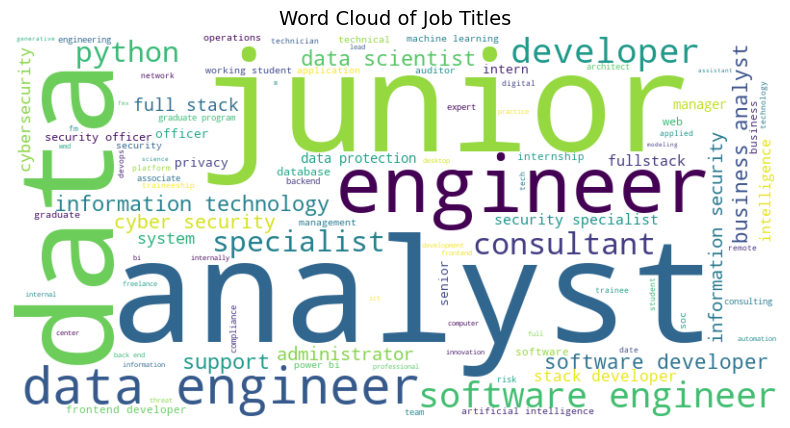

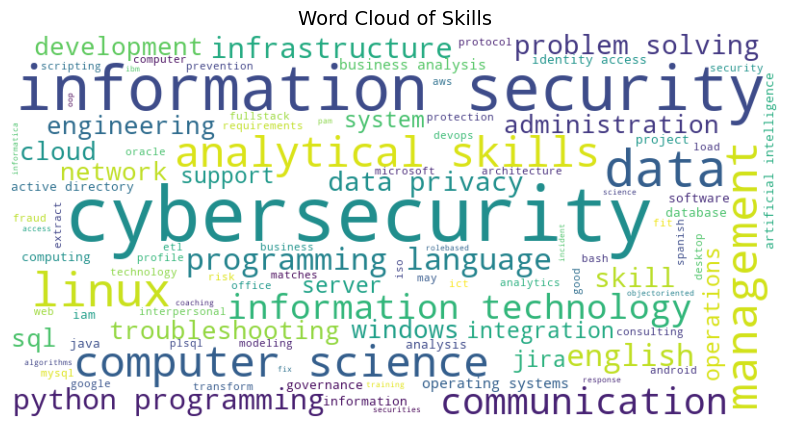

In [102]:
# Generate word clouds
plot_wordcloud(df["Cleaned_Title"], "Word Cloud of Job Titles")
plot_wordcloud(df["Cleaned_Skills"], "Word Cloud of Skills")

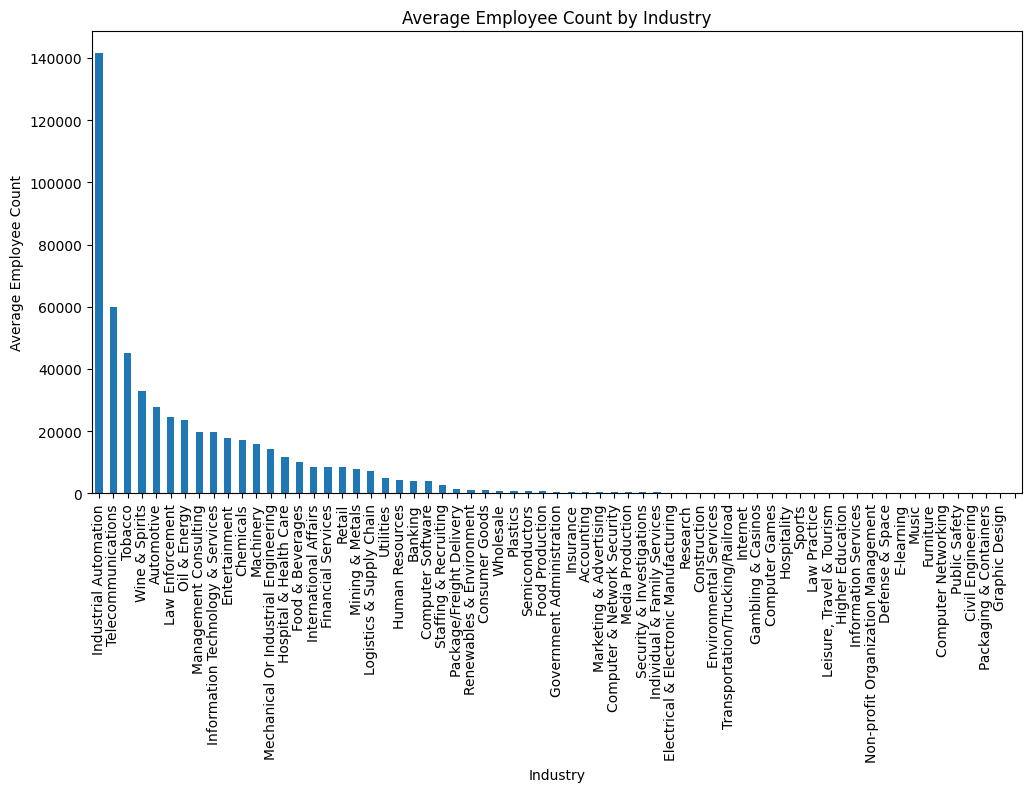

In [135]:
plt.figure(figsize=(12, 6))
df.groupby("Industry")["Employee Count"].mean().sort_values(ascending=False).plot(kind="bar")
plt.xlabel("Industry")
plt.ylabel("Average Employee Count")
plt.title("Average Employee Count by Industry")
plt.show()


In [134]:
df["Location"].value_counts().head(10)

Location
Budapest, Hungary                      63
Budapest, Budapest, Hungary            48
Munich, Bavaria, Germany               11
Madrid, Community of Madrid, Spain     10
Porto, Portugal                        10
Vienna, Austria                         9
Brussels, Brussels Region, Belgium      9
Stockholm, Stockholm County, Sweden     9
Tallinn, Harjumaa, Estonia              8
Rome, Latium, Italy                     8
Name: count, dtype: int64

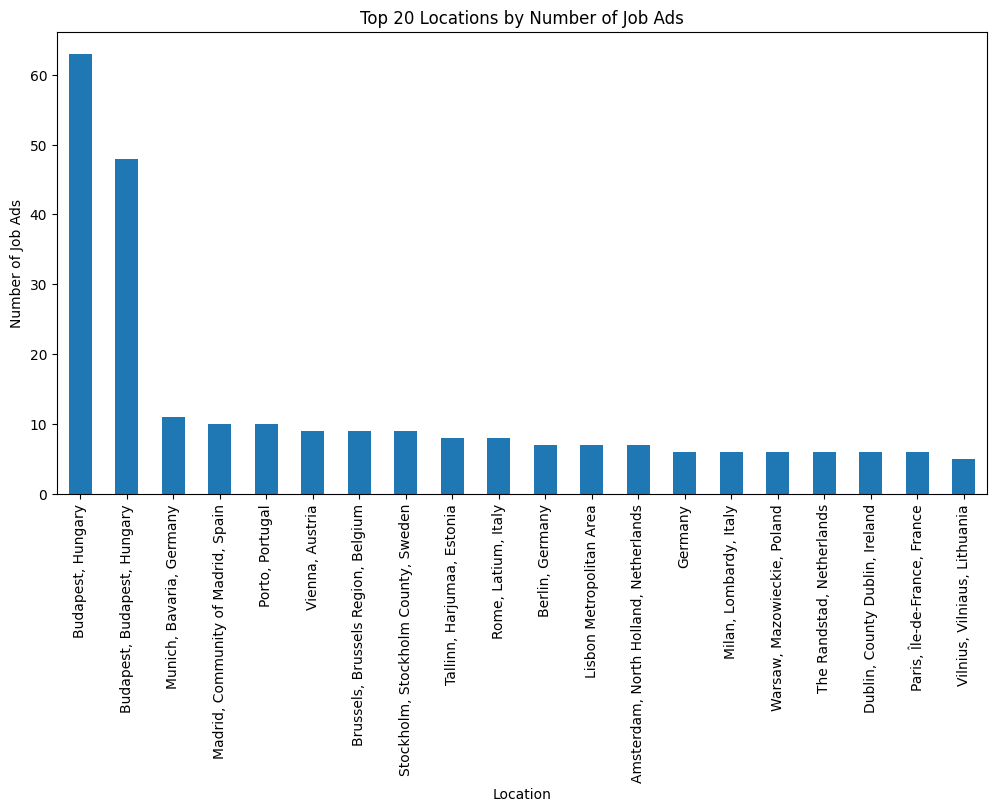

In [136]:
plt.figure(figsize=(12, 6))
df["Location"].value_counts().head(20).plot(kind="bar")
plt.xlabel("Location")
plt.ylabel("Number of Job Ads")
plt.title("Top 20 Locations by Number of Job Ads")
plt.xticks(rotation=90)
plt.show()
